# Predicting Abalone age

The purpose of this notebook is to create a model that predicts the age of an abalone from its physical characterstics as accurately as possible.

Data: [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Abalone)

## Import Data

In [356]:
# Import libraries
import os
import sys

# Update path for notebook location
sys.path[0] = "../"

from urllib.request import urlretrieve, urlopen

from IPython.display import display, HTML # Display functions
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

import seaborn as sns
sns.set_palette("colorblind") 
sns.set_style("darkgrid")

# Set Pandas display options
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

import warnings
warnings.filterwarnings("ignore", category=DeprecationWarning) 

In [357]:
# Set remote URL for retrieval
URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/abalone/'

# Set path to data
path = '../data/raw/'

# Set filenames
filename = 'abalone.data'
names = 'abalone.names'

# Check if data is present
if 'abalone.data' not in os.listdir('../data/raw'):
    urlretrieve(URL + filename, path + filename); # Download raw data
    urlretrieve(URL + names, path + names); # Download column names

In [358]:
# Read in names from text file
with open('../data/raw/abalone.names', 'r') as names:
    lines = list(names)

# Names - for now use this list
names = ['Sex', 'Length', 'Diameter', 'Height', 'WeightWhole', 
         'WeightShucked', 'WeightViscera', 'WeightShell', 'RingCount']

# Read in data
raw = pd.read_csv('../data/raw/abalone.data', names=names, header=None, sep=',');

In [359]:
raw.head()

,Sex,Length,Diameter,Height,WeightWhole,WeightShucked,WeightViscera,WeightShell,RingCount
0,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150,15
1,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070,7
2,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210,9
3,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155,10
4,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055,7


## EDA

In [360]:
raw.shape

(4177, 9)

In [361]:
raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4177 entries, 0 to 4176
Data columns (total 9 columns):
Sex              4177 non-null object
Length           4177 non-null float64
Diameter         4177 non-null float64
Height           4177 non-null float64
WeightWhole      4177 non-null float64
WeightShucked    4177 non-null float64
WeightViscera    4177 non-null float64
WeightShell      4177 non-null float64
RingCount        4177 non-null int64
dtypes: float64(7), int64(1), object(1)
memory usage: 293.8+ KB


The dataset has no missing values or incorrect datatypes.

### Categorical Features

#### Sex

Sex is the only categorical variable. It has 3 classes: 
- M: male
- F: female
- I: infant

In [362]:
# Convert dtype to category
#assert (raw['Sex'].dtype == 'category') | (raw['Sex'].dtype == 'object'), "dtype must be 'category' or 'object'."

Examine distribution:

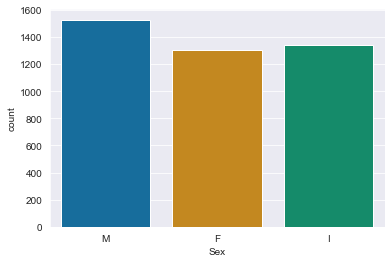

In [363]:
sns.countplot(x="Sex", data=raw);

There are 3 categories in the Sex column and the classes appear to be adequately balanced.

In [364]:
# Pairplots all continuous numeric features
#sns.pairplot(raw, hue="Sex", diag_kind="kde", plot_kws={'alpha': 0.1});

### Numeric Features: *Length, Diameter, Height, WeightWhole, WeightShucked, WeightViscera, WeightShell*

At a glance the pairplot shows some right skew on Length and Diameter, and left skew for adult individuals on the 4 weight columns. There are also some strong correlations present among features, as well as a couple outliers in the Height column.



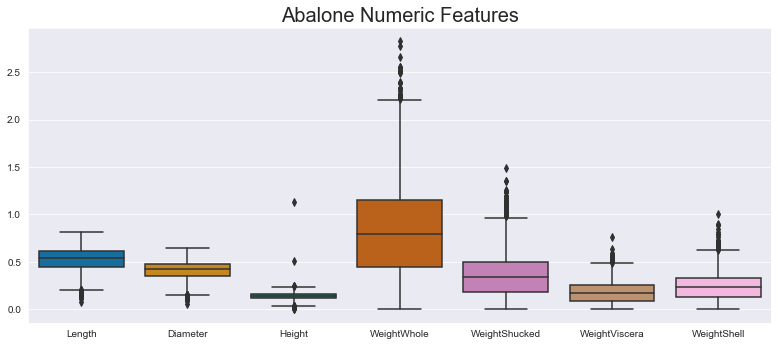

In [365]:
# Selects numeric datatypes
raw_numeric = raw.select_dtypes(include=['float64'])

# Plots boxplot of continuous numeric features
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 6))
sns.boxplot(data=raw_numeric, ax=ax)
plt.title("Abalone Numeric Features", fontsize=20)
plt.tight_layout(pad=5)
plt.show()

### Numeric Features: *RingCount*

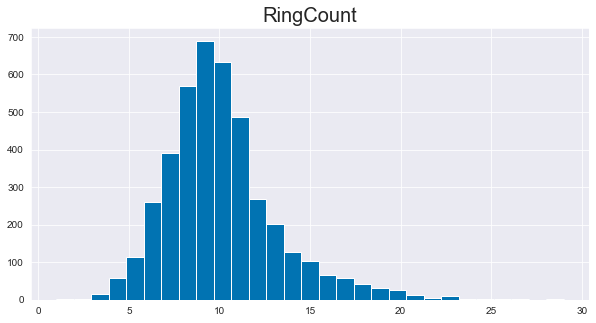

In [366]:
# Selects discrete numeric features
raw.select_dtypes(include='int').head()

# Plots RingCount
raw['RingCount'].hist(figsize=(10, 5), bins=29)
plt.title("RingCount", fontsize=20);

There is slight skew in the age towards younger individuals. Perhaps their probability of being harvested or eaten increases once they exceed a certain size.

In [367]:
# Get value counts by age
raw['RingCount'].value_counts().sort_index()

1       1
2       1
3      15
4      57
5     115
6     259
7     391
8     568
9     689
10    634
11    487
12    267
13    203
14    126
15    103
16     67
17     58
18     42
19     32
20     26
21     14
22      6
23      9
24      2
25      1
26      1
27      2
29      1
Name: RingCount, dtype: int64

### Correlation

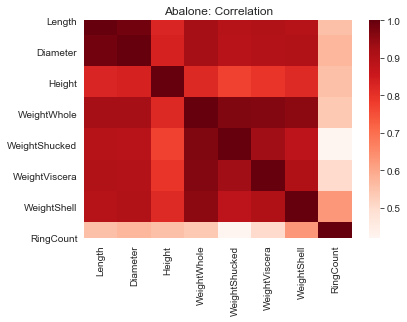

In [368]:
plt.title("Abalone: Correlation")
sns.heatmap(raw.corr(), cmap='Reds');

Length and Diameter appear to have high correlation so we may drop one of them to avoid bias.

## Preprocessing Methods

**RingCount**
* Add 1.5 to calculate age in years

**Sex** 
* Create dummies

**Length, Diameter**
* Drop one
* Standardize
* Remove Outliers

**Height**
* Remove Outliers with Log transform

**WeightWhole, WeightShucked, WeightViscera, WeightShell**
* Normalize

### Feature Engineering: RingCount

In [369]:
raw['RingCount'] = raw['RingCount'] + 1

### Feature Engineering: Sex

Create dummy variables:

In [370]:
# Creates dummy variables
sex_dummies = pd.get_dummies(raw['Sex'], drop_first=True, prefix='Sex')
raw = pd.concat([raw, sex_dummies], axis=1)

### Feature Engineering: Length, Diameter

Drop Length, Standardize

In [371]:
raw.drop('Length', axis=1, inplace=True)

### Feature Engineering: Height

A log transform will handle the outliers:

In [372]:
# Applies log transform
from sklearn.preprocessing import PowerTransformer

log = PowerTransformer(standardize=True)

log.fit(raw[['Height']])

raw['Height_log'] = log.transform(raw[['Height']])

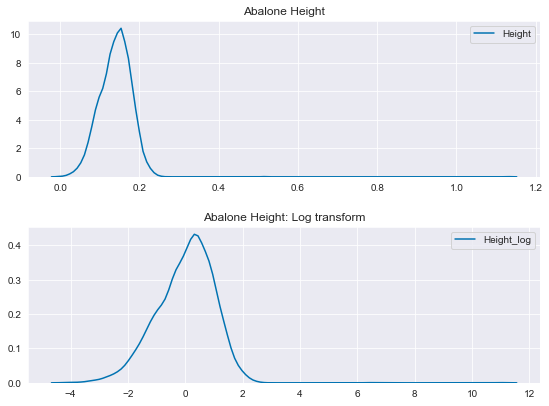

In [373]:
# Graphs different distributions before and after transform
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

sns.kdeplot(raw['Height'], ax=ax[0])
sns.kdeplot(raw['Height_log'], ax=ax[1])

ax[0].set_title('Abalone Height')
ax[1].set_title('Abalone Height: Log transform')

plt.tight_layout(pad=2)

plt.show()

### Feature Engineering: WeightWhole, WeightShucked, WeightViscera, WeightShell

Scale values:

In [374]:
from sklearn.preprocessing import StandardScaler

# Select columns to scale
weight_cols = ['WeightWhole', 'WeightShucked', 'WeightViscera', 'WeightShell']

# Instantiate, fit and transform data
ss = StandardScaler()
weight_transformed = ss.fit_transform(raw[weight_cols])

# Concatenate scaled data with dataframe
weight_transformed = pd.DataFrame(weight_transformed, columns=['Scaled_' + column for column in weight_cols])
raw_scaled = pd.concat([raw, pd.DataFrame(weight_transformed)], axis=1)

In [375]:
# Drops unneeded columns
drop_cols = weight_cols + ['Sex', 'Height']

#drop_cols = ['Sex', 'Height']
#raw = raw.drop(drop_cols, axis=1)
raw_scaled = raw_scaled.drop(drop_cols, axis=1)

In [376]:
raw_scaled

,Diameter,RingCount,Sex_I,Sex_M,Height_log,Scaled_WeightWhole,Scaled_WeightShucked,Scaled_WeightViscera,Scaled_WeightShell
0,0.365,16,0,1,-1.124512,-0.641898,-0.607685,-0.726212,-0.638217
1,0.265,8,0,1,-1.264396,-1.230277,-1.170910,-1.205221,-1.212987
2,0.420,10,0,0,-0.064823,-0.309469,-0.463500,-0.356690,-0.207139
3,0.365,11,0,1,-0.320227,-0.637819,-0.648238,-0.607600,-0.602294
4,0.255,8,1,0,-1.549424,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...,...
4172,0.450,12,0,0,0.666117,0.118813,0.047908,0.532900,0.073062
4173,0.440,11,0,1,-0.064823,0.279929,0.358808,0.309362,0.155685
4174,0.475,10,0,1,1.565082,0.708212,0.748559,0.975413,0.496955
4175,0.485,11,0,0,0.307083,0.541998,0.773341,0.733627,0.410739


## Modeling

**Classification**
- SVM
- KNN
- Naive Bayes

**Regression**
- LinearRegression
- Ridge
- Lasso
- MultiTask Lasso
- ElasticNet

### Create Train & Test sets

In [377]:
from sklearn.model_selection import train_test_split

# Create training and target data
#X, y = raw.drop('RingCount', axis=1), raw['RingCount']
X, y = raw_scaled.drop('RingCount', axis=1), raw_scaled['RingCount']

# Split test and training data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

X_train.shape, y_train.shape

((3341, 8), (3341,))

In [404]:
X

,Diameter,Sex_I,Sex_M,Height_log,Scaled_WeightWhole,Scaled_WeightShucked,Scaled_WeightViscera,Scaled_WeightShell
0,0.365,0,1,-1.124512,-0.641898,-0.607685,-0.726212,-0.638217
1,0.265,0,1,-1.264396,-1.230277,-1.170910,-1.205221,-1.212987
2,0.420,0,0,-0.064823,-0.309469,-0.463500,-0.356690,-0.207139
3,0.365,0,1,-0.320227,-0.637819,-0.648238,-0.607600,-0.602294
4,0.255,1,0,-1.549424,-1.272086,-1.215968,-1.287337,-1.320757
...,...,...,...,...,...,...,...,...
4172,0.450,0,0,0.666117,0.118813,0.047908,0.532900,0.073062
4173,0.440,0,1,-0.064823,0.279929,0.358808,0.309362,0.155685
4174,0.475,0,1,1.565082,0.708212,0.748559,0.975413,0.496955
4175,0.485,0,0,0.307083,0.541998,0.773341,0.733627,0.410739


### Evaluating Models

In [384]:
# Import regressors
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge
from sklearn.linear_model import Lasso
from sklearn.linear_model import MultiTaskLasso
from sklearn.linear_model import ElasticNet
from sklearn.ensemble import RandomForestRegressor

# Import metrics
from sklearn.model_selection import cross_val_score

# Function to performs cross-validation scoring
def evaluate_clf(clf, metric=None):
    clf.fit(X_train, y_train)
    score = cross_val_score(clf, X, y, cv=10, scoring=metric).mean()
    
    return score

# Initialize dictionary to hold name:score key value pairs
model_dict = {}

# Evaluating classifiers
clf_list = [SVC(), KNeighborsClassifier(), GaussianNB()]
clf_name = ["SVC", "KNN", "Naive Bayes"]
metric = 'accuracy'

for name, model in zip(clf_name, clf_list):
    model.fit(X_train, y_train)
    model_dict.update({name:evaluate_clf(model)})

# Evaluating regressors
clf_list = [LinearRegression(), Ridge(), Lasso(), ElasticNet(), RandomForestRegressor()]
clf_name = ["LinearRegression", "Ridge", "Lasso", "ElasticNet", "RandomForestRegressor"]
metric = 'neg_mean_squared_error'
    
for name, model in zip(clf_name, clf_list):
    model.fit(X_train, y_train)
    model_dict.update({name:evaluate_clf(model)})

# Convert dict to dataframe
models_df = pd.DataFrame.from_records([model_dict]).T.sort_values(by=0, ascending=False)
models_df.columns = ["Score"]

/Users/gregory/anaconda3/envs/uci_abalone_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/gregory/anaconda3/envs/uci_abalone_env/lib/python3.7/site-packages/sklearn/svm/base.py:193: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
/Users/gregory/anaconda3/envs/uci_abalone_env/lib/python3.7/site-packages/sklearn/model_selection/_split.py:657: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=10.
  % (min_groups, self.n_splits)), Warning)
/Users/gregory

In [382]:
models_df

,Score
Ridge,0.371852
LinearRegression,0.369797
RandomForestRegressor,0.344225
SVC,0.268116
KNN,0.224146
ElasticNet,0.173411
Lasso,0.141033
Naive Bayes,0.108611


The highest scoring models were Ridge and LinearRegression. Next we will find the best hyperparameters for these models.

### Hyperparameters: Ridge vs LinearRegression

In [406]:
X.columns

Index(['Diameter', 'Sex_I', 'Sex_M', 'Height_log', 'Scaled_WeightWhole', 'Scaled_WeightShucked', 'Scaled_WeightViscera', 'Scaled_WeightShell'], dtype='object')

In [ ]:
from sklearn.model_selection import GridSearchCV

ridge_params = {"alpha":[0.01, 1, 10], "fit_intercept":[True, False], "normalize":[True, False]}
linreg_params = {"fit_intercept":[True, False], "normalize":[True, False]}
rf_params = {"n_estimators":[10, 100], "max_depth":[0.1, 1, 10, 100], "min_samples_split":np.linspace(0.1, 1, 10), 
            "min_samples_leaf":[0.01, .1, 1, 10]}

models = [Ridge(), LinearRegression(), RandomForestRegressor()]
model_names = ["Ridge", "LinReg", "RF"]
model_params = [ridge_params, linreg_params, rf_params]
best_params = []

def find_params(model, params):
    model_cv = GridSearchCV(model, params, scoring='neg_mean_squared_error', cv=5)
    model_cv.fit(X, y)
    print("Score: {}\nBest Parameters: {}".format(-model_cv.best_score_, 
                                                  model_cv.best_params_))
    return model_cv.best_params_

# Hyperparameters
for model, p in zip(models, model_params):
    print(model)
    find_params(model, p)

Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)
Score: 5.136691066910781
Best Parameters: {'alpha': 1, 'fit_intercept': True, 'normalize': False}
LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)
Score: 5.140778226541079
Best Parameters: {'fit_intercept': True, 'normalize': True}
RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
                      max_features='auto', max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, n_estimators='warn',
                      n_jobs=None, oob_score=False, random_state=None,
                      verbose=0, warm_start=False)


It looks like Ridge has slightly lower RMSE.

In [328]:
alpha = np.linspace(0.1, 10, 100)
train_accuracy = np.empty(len(alpha))
test_accuracy = np.empty(len(alpha))

# Score for values of n_neighbors
for i, k in enumerate(alpha):
    r = Ridge(alpha=k, normalize=True)
    
    r.fit(X_train, y_train)
    
    # Collects test accuracy values
    train_accuracy[i] = r.score(X_train, y_train)
    
    # Collects train accuracy values
    test_accuracy[i] = r.score(X_test, y_test)

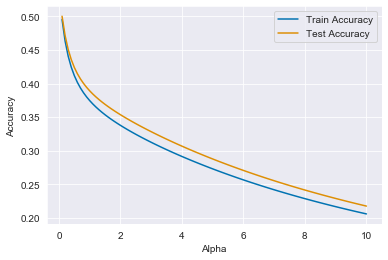

In [329]:
# Plots Ridge accuracy with different alpha
plt.plot(alpha, train_accuracy, label="Train Accuracy")
plt.plot(alpha, test_accuracy, label="Test Accuracy")
plt.legend()
plt.xlabel("Alpha")
plt.ylabel("Accuracy")
plt.show()

In [330]:
# Using best parameter alpha=1
r = Ridge(alpha=1)

r.fit(X, y)

cross_val_score(r, X, y, cv=10).mean()

0.3718519225314159